## Generating truncated random variates

In this note, I briefly describe how to efficiently generate random variables from a truncated distribution that is sampling from $p(X \mid a < X \le b)$.  The method I will describe is fairly general as it only assumes access to the cumulative distribution function (CDF) and quantile function (also known as the inverse CDF or percent-point function (PPF)).

Let $X \sim \mathcal{D}$ be a univariate random variable from a distribution $\mathcal{D}$ with 
cumulative distribution function $F$,
probability density function $f$,
and quantile function $F^{-1}$.  Below, I give an example of these functions for a normal distribution.

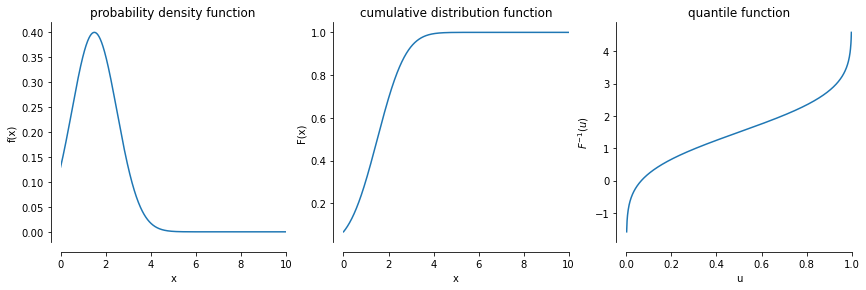

In [1]:
import scipy.stats as st
from arsenal.maths import show_distr
D = st.norm(1.5)
show_distr(D, 0, 10);

**Truncation:** Suppose we'd like to sample from $\mathcal{D}$ conditioned on the value of $X$ lying in a range $a < X \le b$.  This is known as a truncated random variable.  Truncation, like any type of conditioning operation, may be regarded as "rejecting" a sample from $\mathcal{D}$ if it does not lie in the interval $(a,b]$.  We will return to this rejection idea when we test our implementation of the truncation operation.

Let $\mathcal{T}$ denote the truncated distribution, $p(X \mid a < X \le b)$


- Probability density function

$$
t(x) = \begin{cases}
\frac{ f(x) }{ F(b) - F(a) } & \text{if } a < x \le b \\
0 & \text{otherwise}
\end{cases}
$$

- Cumulative distribution function

$$
T(x) = \begin{cases}
\frac{ F(x) - F(a)  }{ F(b) - F(a) } & \text{if } a < x \le b \\
1 & \text{if } x > b \\
0 & \text{otherwise}
\end{cases}
$$

- Quantile function

$$
T^{-1}(u) = F^{-1}(F(a) + u \cdot (F(b) - F(a)))
$$


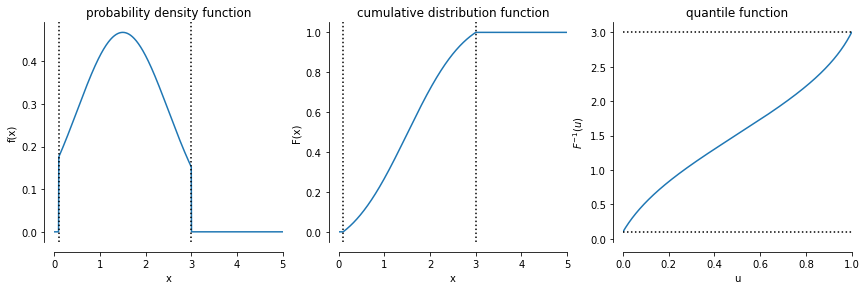

In [2]:
from arsenal.maths.rvs import TruncatedDistribution
T = TruncatedDistribution(D, a=.1, b=3)
ax = show_distr(T, 0, 5)

ax[0].axvline(T.a, linestyle=':', c='k')
ax[0].axvline(T.b, linestyle=':', c='k')
ax[1].axvline(T.a, linestyle=':', c='k')
ax[1].axvline(T.b, linestyle=':', c='k')
ax[2].axhline(T.a, linestyle=':', c='k')
ax[2].axhline(T.b, linestyle=':', c='k');

**Sampling:** The [inverse transform method](https://en.wikipedia.org/wiki/Inverse_transform_sampling) says that I can generate from $\mathcal{D}$ by transforming a uniform random variate $U \sim \mathcal{U}(0,1)$,

$$F^{-1}(U) \sim \mathcal{D}$$

We can sample from our truncated distribution by the exact same mechanism.

## Implementation

Below, is a simple implementation of these ideas which is available in [arsenal.maths.rvs.TruncatedDistribution](https://github.com/timvieira/arsenal).  The implementation is meant to work with the distributions in `scipy.stats`.  Note the `ppf` is the quantile function, and `rvs` is a method to sample from the distribution.

In [3]:
from arsenal.nb import psource
from arsenal.maths.rvs import TruncatedDistribution
psource(TruncatedDistribution)

We compare our inverse transform method from truncated generation to an inefficient rejection sampling approach which repeatedly samples from $\mathcal{D}$ until the sample lies the interval $[a,b]$.

In [4]:
def truncated_generator_slow(D, a, b, max_rejections=10000):
    "Sample X ~ D( X | a ≤ X ≤ b) with rejection sampling."
    assert a < b, [a,b]
    rejections = 0
    while True:
        x = D.rvs()
        if a <= x <= b:
            return x
        rejections += 1
        if rejections > max_rejections:
            assert False, 'too many rejections'

In [5]:
from arsenal import iterview

In [6]:
def compare_to_rejection(
    D, a, b,
    m: 'number of samples' = 100_000,
    B: 'number of histogram bins' = 50,
):
    T = TruncatedDistribution(D, a, b)
    samples = T.rvs(m)
    pl.hist(samples, bins=B, density=True, color='r', alpha=0.5, label='histogram')

    samples = [truncated_generator_slow(D, a, b) for _ in iterview(range(m))]
    pl.hist(samples, bins=B, color='b', alpha=0.5, density=True, 
            label='rejection histogram')

    xs = np.linspace(a, b, 1000)
    pl.plot(xs, T.pdf(xs), c='k',
            label='pdf')

    # show truncation lines
    pl.axvline(a, c='k', linestyle=':', zorder=100)            
    pl.axvline(b, c='k', linestyle=':', zorder=100, label='bounds')
    pl.xlim(0, b * 1.2)
    
    pl.legend(loc='best')
    pl.title('truncated distribution');

100.0% (100000/100000) [==============================================] 00:00:04


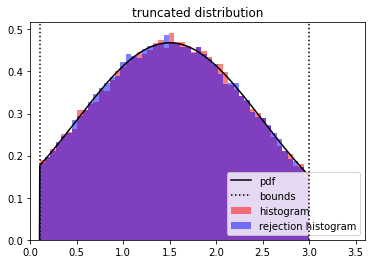

In [7]:
compare_to_rejection(D, T.a, T.b)

Let's test out the generality of our approach on a Gumbel distribution.

100.0% (100000/100000) [==============================================] 00:00:10


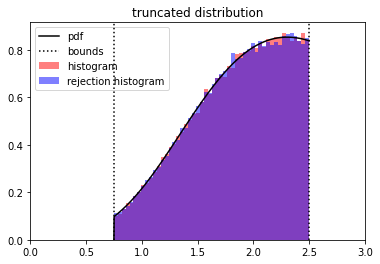

In [8]:
compare_to_rejection(
    D = st.gumbel_r(np.log(10)),
    a = 0.75,
    b = 2.5
)

### Testing the analytical forms for the pdf, cdf, and ppf

The test cases below show that the empirical distribution of the rejection sampler matches the analytical versions of the pdf, cdf, and ppf that we implemented.

In [9]:
from arsenal.maths import Empirical, compare_samples_to_distr
samples = [truncated_generator_slow(D, T.a, T.b) for _ in iterview(range(100_000))]

100.0% (100000/100000) [==============================================] 00:00:04


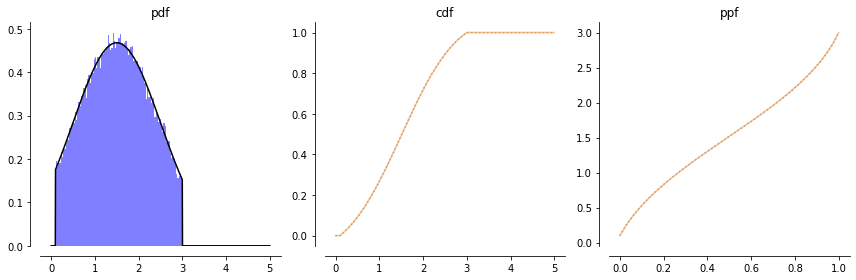

In [10]:
compare_samples_to_distr(T, samples, 0, 5, bins=100);

We can also check that the fast sampler matches in the same ways as above.

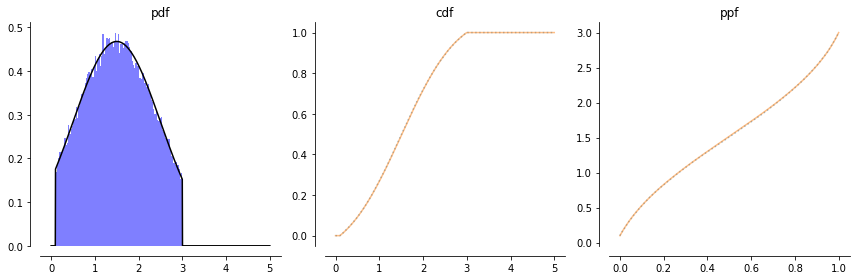

In [11]:
compare_samples_to_distr(T, T.rvs(100_000), 0, 5, bins=100);